In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
"""
Since we are using PyTorch for our Neural Network for image classification, they offer GPU acceleration.
If you have a computer with an NVIDIA GPU, you can take advantage of the speed increases that it offers. This
check will let you know if you are utilizing your GPU or CPU. If you don't have a GPU, no problem it may just
take more time to train the model. For instructions on the proper GPU installation you need CUDA and cuDNN, please 
check out the PyTorch docs: https://pytorch.org/get-started/locally/
"""

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU")
else:
    device = torch.device("cpu")
    print("Using CPU")

Using GPU


In [3]:
"""
Now comes for the feature creation, here we apply transformations/augmentations to our image data. This can provide us
with more data without actually going out and collecting more data. This also helps to make our classification model
generalize better. The reason for this is because we initially have one image of a car for example, if we rotate the car image 
90 degrees clockwise and save it, we now just doubled our car images from 1 to 2. This will also help the model recognize a 
car image that may be taken off axis. Where as before it may have struggled because it never seen a car off rotation. 
We also need to perform similar augmentations to our test set to ensure that the images are the same size and have the same 
amount of colors. Just keep in mind that the more augmentations we apply to our data, we will need to apply to all new 
incoming data we will try to classify because our model is now expecting data in that format.
"""

train_transforms = transforms.Compose([transforms.Grayscale(1),
                                       transforms.RandomRotation(25),
                                       transforms.RandomHorizontalFlip(.25),
                                       transforms.RandomVerticalFlip(.25),
                                       transforms.Resize(50),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5), (0.5))])

test_transforms = transforms.Compose([transforms.Grayscale(1),
                                      transforms.Resize(50),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5), (0.5))])

In [4]:
"""
Here we load the CIFAR-10 dataset from PyTorch. We apply the transforms the created above and we shuffle the data in the 
training set to ensure our model doesn't learn to predict the data by learning the order they appear rather than features
within the images themselves. We also use the torch Data Loader class to batch our data up, batching allows for us to train
the model utilizing less memory since we only need to store the batched data in memory rather than the whole dataset.
"""

cifar_train_data = datasets.CIFAR10('./data/train/', train=True, transform=train_transforms, download=True)
train_data_loader = torch.utils.data.DataLoader(cifar_train_data, batch_size=64, shuffle=True)
train_it = iter(train_data_loader)

cifar_test_data = datasets.CIFAR10('./data/test/', train=False, transform=test_transforms, download=True)
test_data_loader = torch.utils.data.DataLoader(cifar_test_data, batch_size=64, shuffle=False)
test_it = iter(test_data_loader)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# This is the label mapping from the dataset to the classes of each of the images
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

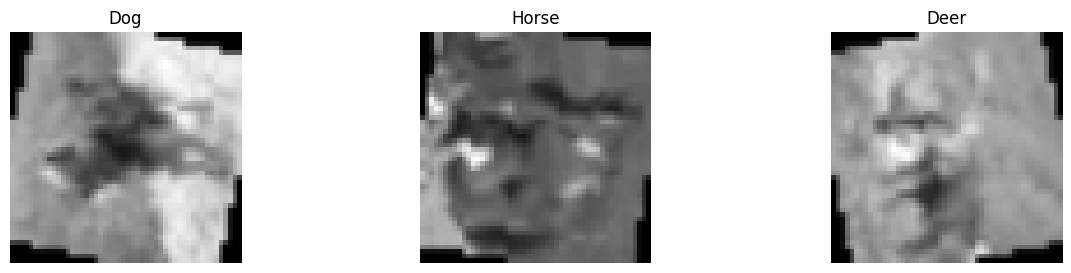

In [6]:
"""
Created a function that allows for data exploration and visualization of the training data after the transformations have
been applied. Even though on each iteration, we get more than three images in a batch, we only display 3 for ease of viewing.
"""

def display_loader_images(iterator):
    image, label = next(iterator)
    
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,3))
    
    for i in range(3):
        ax[i].imshow(image[i].permute(2, 1, 0), cmap='gray')
        ax[i].axis('off')
        ax[i].set_title(classes[label[i]].title())
    plt.show()
    
display_loader_images(train_it)

Files already downloaded and verified


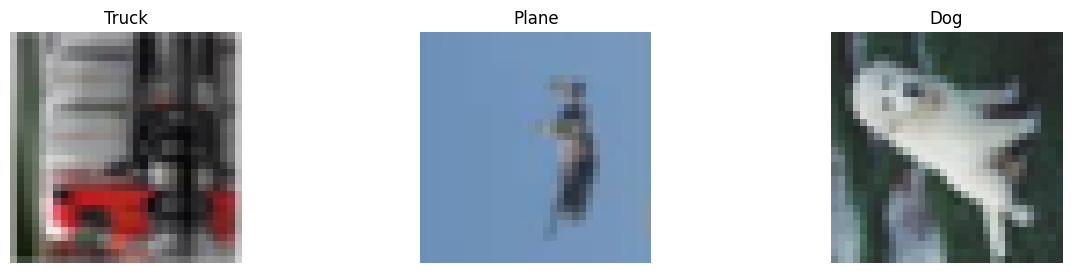

In [7]:
"""
Here we load the CIFAR dataset again just to see what the images look like without any transformations applied on them.
Notice how they have full color and the ones above with the transofrmations have no color, this is because we greyscale the 
images which helps to reduce dimensionality of the data and speeds up model training and efficiency.
"""

visualize_raw_data = datasets.CIFAR10('./data/train/', train=True, transform=transforms.ToTensor(), download=True)
visualize_raw_data_loader = torch.utils.data.DataLoader(visualize_raw_data, batch_size=3, shuffle=True)
display_loader_images(iter(visualize_raw_data_loader))

In [8]:
"""
Here we are doing some extra data exploration stuff just to get a feel for the shapes of our arrays that we would be feeding
into the model. Also we would want to get an understanding of the size of our dataset we are working with. Understanding the 
size of training and tetsing datasets will help with understanding how long it will take your model to train. The more data
you have the longer it will take for your model to see all of that data and learn it.
"""

print(f"Total training data size: {len(train_data_loader.dataset)}")
print(f"Total testing data size: {len(test_data_loader.dataset)}")
print(f"Number of training batches: {len(train_it)}")
print(f"Number of testing batches: {len(test_it)}")
print(f"Image Shape: {next(train_it)[0].shape}")
print(f"Label Shape: {next(test_it)[1].shape}")

Total training data size: 50000
Total testing data size: 10000
Number of training batches: 782
Number of testing batches: 157
Image Shape: torch.Size([64, 1, 50, 50])
Label Shape: torch.Size([64])


In [9]:
"""
We create the classifier model using the Module container from PyTorch. We definately didn't need to use this container, as we
could have opted for the use of a Sequential model as that fits our use case better because we are just executing layers top
down without more complicated things like residual and skip connections, etc. I chose to use the Module container because I
feel it will be more helpful to understand this container first and it allows for tons of flexibility. Then once you understand
this model, understanding the Sequential containers will be super easy. When creating a model in pytorch, you need two 
functions on your class. You need an init function for initializing the model with your params and layers. The second function
is a forward function which is called when you pass data to the model. In our init function in this case, we initialize all 
of our layers and the parameters for each of them. Then our forward function actually propagates the input data, in this case 
the batch of images, through each of the layers and returns the final array, in this case the logits. Logits are basically
the probabilities that the model predicts for each of the classes. They will range from 0-1 and the sum of all logits for each
image will add up to 1. For example, an output may look like [0.09, 0.01, 0.05, 0.05, 0.0, 0.8, 0.0, 0.0, 0.0, 0.0]. 
Thus when it comes time to make the prediction we will pick the max logit, in this case is the 5th position which is a dog.
"""

class CIFARClassifier(nn.Module):
    def __init__(self, hidden_size, output_size):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 128, 3)
        self.conv3 = nn.Conv2d(128, 256, 3)
        
        self.flatten = nn.Flatten()
        
        self.linear1 = nn.LazyLinear(hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, hidden_size)
        self.linear4 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = F.max_pool2d(self.conv1(x), (2,2))
        x = F.max_pool2d(self.conv2(x), (2,2))
        x = F.max_pool2d(self.conv3(x), (2,2))
        
        x = self.flatten(x)
        
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        x = self.linear4(x)
        return x

In [10]:
"""
Now we define some hyperparameters that we can tune. Learning rate controls the step size based on the calculated gradient
from the loss function. I describe this a lot more in detail in my Gradient Descent notebook so feel free to check it out
over in that notebook if you need more information. The other hyperparameter we have is the amount of epochs, this is how
many times we iterate through the entire dataset. After the hyperparameters, we need to create an instance of our model, and
choose our loss function and optimizer. 
"""

learning_rate = 1e-3
EPOCHS = 50

cifar_model = CIFARClassifier(256, len(classes)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cifar_model.parameters(), lr=learning_rate)

C:\Users\Joe\.virtualenvs\CIFAR_Classifier-yrOipxWQ\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [11]:
cifar_model

CIFARClassifier(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): LazyLinear(in_features=0, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=256, bias=True)
  (linear3): Linear(in_features=256, out_features=256, bias=True)
  (linear4): Linear(in_features=256, out_features=10, bias=True)
)

In [12]:
"""
This is the important part, this is the training loop. This is where the model gets the images and learns. In basic terms, we
iterate through our training data and use our model to make predictions on each of the images. Then we use the loss function
to tell us how bad our model performed compared to what we expected (our ground truth). We then calculated the gradients based
on this loss function and tune the model parameters based on those gradients and our learning rate. We also make sure to store 
the training loss. In the later part of the loop we put our model in eval mode. This important because there are some layers 
in models that operate differntly in training and evaluate mode (such as Dropout and BatchNorm). Even though none of those 
layers are used in this case, I believe that it is a good habit to get into because it can't hurt. Then we feed in our 
testing data can store out testing accuracy and loss. We can monitor the training and testing loss and make sure they are
close to each other and they aren't diverging from one another. If they are diverging then that tells you the model is starting
to overfit. This is not what we want because the model will perform better on insample data but its ability to perform 
predictions on out of sample data will suffer.
"""

train_loss_history = []
test_loss_history = []
test_accuracy_history = []

for epoch in range(EPOCHS):
    train_loss = 0.0
    test_loss = 0.0
    test_accuracy = 0.0
    
    cifar_model.train()
    for image, label in train_data_loader:
        image, label = image.to(device), label.to(device)
        
        optimizer.zero_grad()
        
        pred_logits = cifar_model(image)
        loss = loss_fn(pred_logits, label)
        train_loss += loss.detach().item()
        
        loss.backward()
        optimizer.step()
    
    cifar_model.eval()
    with torch.no_grad():
        for image, label in test_data_loader:
            image, label = image.to(device), label.to(device)
            
            pred_logits = cifar_model(image)
            test_loss += loss_fn(pred_logits, label).detach().item()
            test_accuracy += (pred_logits.argmax(1) == label).type(torch.int).sum().detach().item()
    
    
    train_loss /= len(test_data_loader)
    test_loss /= len(test_data_loader)
    test_accuracy /= len(test_data_loader.dataset)
    
    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)
    test_accuracy_history.append(test_accuracy)
    
    print(f"Epoch: {epoch} - Training Loss: {train_loss} - Testing Loss: {test_loss} - Testing Accuracy: {test_accuracy}")

Epoch: 0 - Training Loss: 8.938208673410355 - Testing Loss: 1.4629680601654538 - Testing Accuracy: 0.4772
Epoch: 1 - Training Loss: 7.498252665920622 - Testing Loss: 1.2769273230983953 - Testing Accuracy: 0.5561
Epoch: 2 - Training Loss: 6.824633458997034 - Testing Loss: 1.1835452489032867 - Testing Accuracy: 0.5858
Epoch: 3 - Training Loss: 6.369286661694764 - Testing Loss: 1.1381076487006656 - Testing Accuracy: 0.6074
Epoch: 4 - Training Loss: 6.066958004501974 - Testing Loss: 1.078346771419428 - Testing Accuracy: 0.6279
Epoch: 5 - Training Loss: 5.8042970398429095 - Testing Loss: 1.0364969289226897 - Testing Accuracy: 0.6438
Epoch: 6 - Training Loss: 5.65116620025817 - Testing Loss: 1.0060486865651077 - Testing Accuracy: 0.6496
Epoch: 7 - Training Loss: 5.453125067956888 - Testing Loss: 1.005280383832895 - Testing Accuracy: 0.6604
Epoch: 8 - Training Loss: 5.30964202637885 - Testing Loss: 1.0051590386469653 - Testing Accuracy: 0.6537
Epoch: 9 - Training Loss: 5.201923096635539 - Tes

In [13]:
metrics_dict = {0: {'title': 'Train Loss',
                    'data': train_loss_history},
                1: {'title': 'Test Loss',
                    'data': test_loss_history},
                2: {'title': 'Accuracy Loss',
                    'data': test_accuracy_history}}

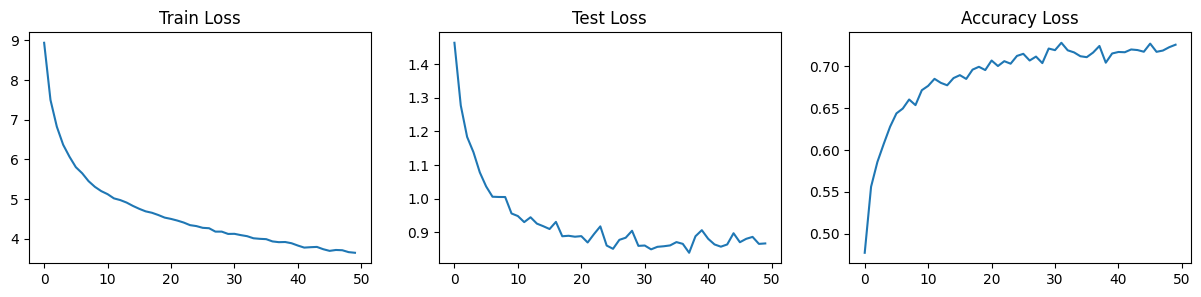

In [14]:
"""
We create a small little metrics function to take all of the metrics data we collected from our training loop and display the
plots of them so we can see a trend in the training and testing loss as well as our accuracy of the model.
"""

def display_metrics(metrics_dict):        
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,3))
    
    for i in range(3):
        ax[i].plot(metrics_dict[i]['data'])
        ax[i].set_title(metrics_dict[i]['title'].title())
    plt.show()
    
display_metrics(metrics_dict)

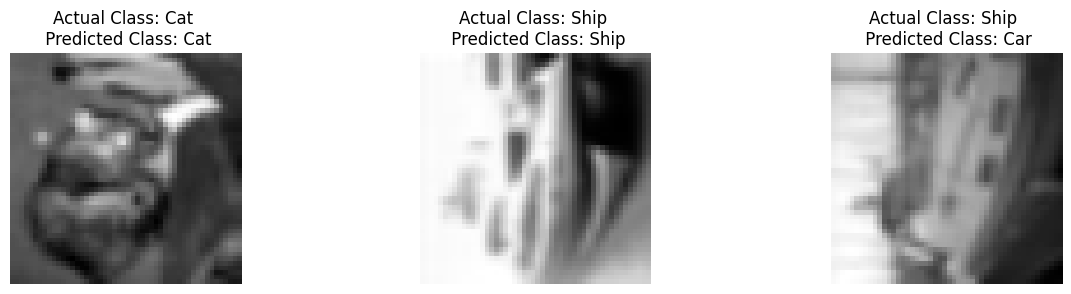

In [15]:
"""
Here is a function that take in a data loader object as well as the model. It uses the model to make predictions based on the
image. It then displays the image as well as the actual label vs. the predicted label.
"""

def display_predictions(data_loader, model):
    device = next(model.parameters()).device
    data_it = iter(data_loader)
    image, label = next(data_it)
    
    model.eval()
    pred_logits = model(image.to(device))
    pred_classes = pred_logits.argmax(1).type(torch.int).detach()
    
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,3))
    for i in range(3):
        ax[i].imshow(image[i].permute(2, 1, 0), cmap='gray')
        ax[i].axis('off')
        ax[i].set_title(f'Actual Class: {classes[label[i]].title()} \n '+ \
                        f'Predicted Class: {classes[pred_classes[i]].title()}')
    plt.show()
    
display_predictions(test_data_loader, cifar_model)

In [16]:
"""
Finally one of the last things we can do is save the model for later use or if we need to transfer it around.
"""

torch.save(cifar_model.state_dict(), 'cifar-10_model.pth')

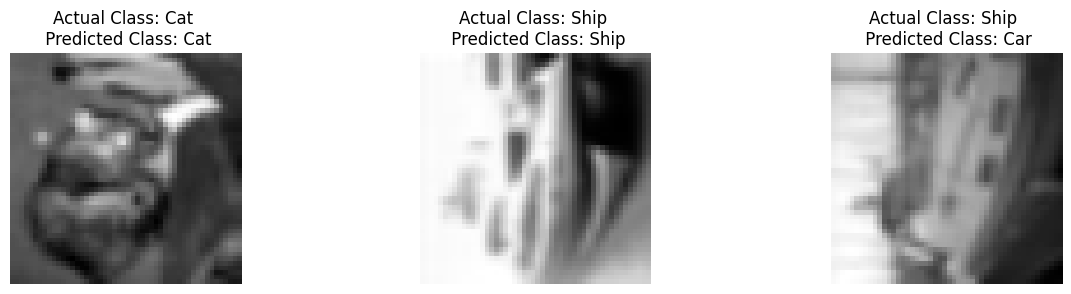

In [17]:
"""
If we need to reload the model from the stored version, this is how we would go about doing it. Just make sure that when you are 
re-loading the model, you use the same args and kwargs when training the model, otherwise the loading will throw an error. 
Once the model is loaded you can use pass images to it like before and it will continue to make predictions.
"""
reloaded_model = CIFARClassifier(256, len(classes)).to(device)
reloaded_model.load_state_dict(torch.load('cifar-10_model.pth'))
reloaded_model.eval()

display_predictions(test_data_loader, reloaded_model)